In [ ]:
#P(Y|do(X)) != P(Y|X)

#P(Y|do(X)) def= sum_q P(y,q|do(x))
            #def= sum_q P(t|do(x),q) P(q|do(x))
                #= sum_q P(y|x,q) P(q) las q cumplen el backdoor y cierran el flujo de inferencia trasero entre X e Y, hacer intervencion sobre x es independiende de lo que pasa en otro lado (las de q)

#P(y|do(X),q)=

#1

In [ ]:
import random
import numpy as np
from numpy.random import normal as noise
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm
from scipy.stats import uniform
from scipy import stats

In [ ]:
np.random.seed(123)

In [ ]:
import linear_model as lm
from linear_model import BayesianLinearModel

In [ ]:
N = 5000
def simular1(N=5000, do_x=None):
# Si hay intervencion, usar x = do_x, sino generarlo del modelo original
    Z = np.random.uniform(-3,3, size=N)
    if do_x is None:
        X = 1 + 3*Z + 2*Z**3 + np.random.normal(size=N,scale=6)
    else:
        X = np.full(N, do_x)
    Y = -1 - 2*X + 6*Z**2 + np.random.normal(size=N,scale=1)
    return Z, X, Y

# Generamos los datos sin intervenciones
N = 5000
Z1s, X1s, Y1s = simular1(N)
#Mostramos un ejemplo de c´omo usar la librer´ıa lineal model.
# Creamos el modelo
PHI1 = np.concatenate([
  np.ones(N).reshape(N, 1), # c_0
  X1s.reshape(N, 1), # c_x X
  (Z1s**2).reshape(N, 1)], # c_z Z^2
  axis=1)

# Ajustamos el modelo
blm1= BayesianLinearModel(basis=lambda x: x)
blm1.update(PHI1, Y1s.reshape(N,1) )

# Obtenemos las estimaciones
mean1 = blm1.location
cov1 = blm1.dispersion
ev1 = blm1.evidence()

In [ ]:
print(ev1)

-7141.316380939304


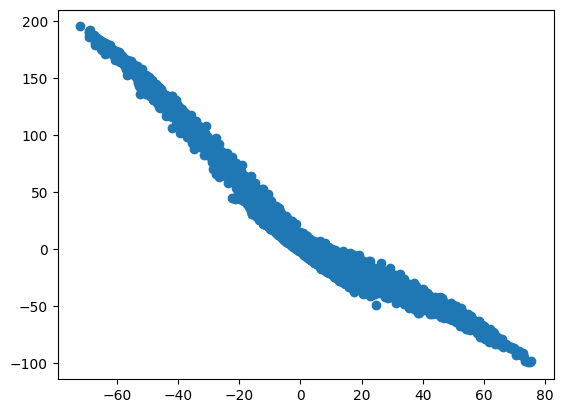

In [ ]:
plt.scatter(X1s,Y1s)
plt.show()

In [ ]:
#y = w0 + w1 x + w2 z
# P(y|x,z,w) = N( y | w0+w1*x+w2*z, beta^{-1})
PHI1a = np.concatenate([
  np.ones(N).reshape(N, 1), # c_0
  X1s.reshape(N, 1),
  Z1s.reshape(N, 1)],
  axis=1)

# Ajustamos el modelo
blm1a= BayesianLinearModel(basis=lambda x: x)
blm1a.update(PHI1a, Y1s.reshape(N,1) )


In [ ]:
blm1a.location

array([[17.28164484],
       [-2.05429077],
       [ 0.48441376]])

In [ ]:
blm1a.dispersion

array([[ 2.01545174e-04, -1.71537404e-06,  2.48136092e-05],
       [-1.71537404e-06,  1.92332725e-06, -2.66968819e-05],
       [ 2.48136092e-05, -2.66968819e-05,  4.36484361e-04]])

In [ ]:
blm1a.evidence()

-21045.13274098684

In [ ]:
x=0; z=0; y=1
# Efecto causal de x en y para z especifico
# P(y|do(x),z) = P(y|x,z) = sum_w P(y|x,z,w) P(w)
_,_,py_xz = blm1.predict(
    X = np.array([1,x,z**2]).reshape((1,3)),
    y = np.array([y]))

In [ ]:
_,_,py_xz = blm1a.predict(
    X = np.array([1,x,z]).reshape((1,3)),
    y = np.array([y]))

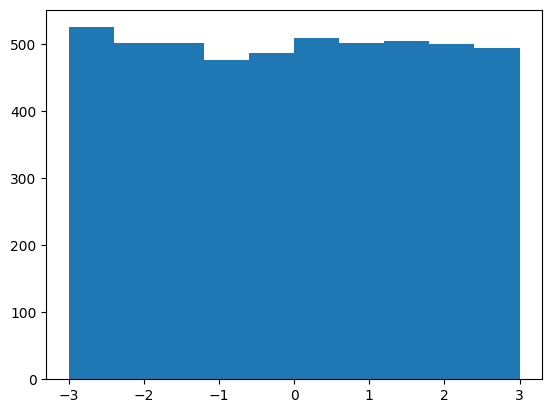

In [ ]:
plt.hist(Z1s)
plt.show()

In [ ]:
#P(y|do(x)) = /integral P(y|x,z) P(z) dz

In [ ]:
def p1_Y_doX(y,x,blm=blm1, dz=0.01):
  res = 0
  for z in np.arange(-3,3+dz,dz):
    _,_,py_xz = blm.predict(
      X = np.array([1,x,z**2]).reshape((1,3)),
      y = np.array([y]))
    #pz = uniform.pdf(z,-3,6)
    pz = 1/6
    res = res + py_xz*pz*dz
    #res += py_xz*pz
  return res


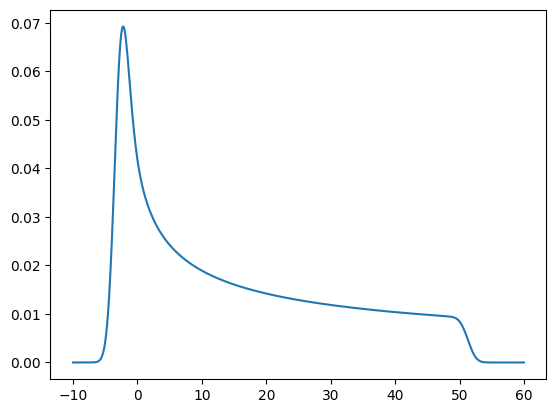

In [ ]:
dy = 0.05
y_grilla = np.arange(-10,60,dy)
plt.plot(y_grilla, p1_Y_doX(y_grilla,x=1))
plt.show()

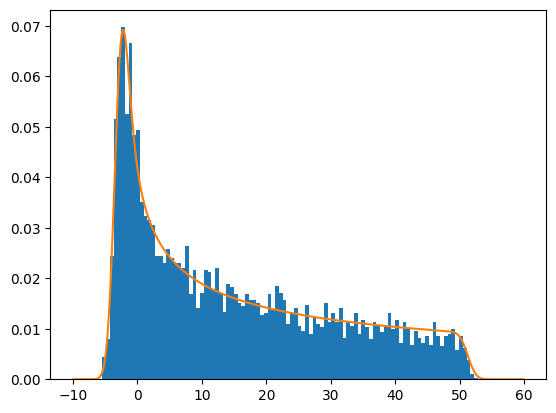

In [ ]:
_,_,Yx1 = simular1(N=5000, do_x=1)
plt.hist(Yx1, bins=100, density=True)
plt.plot(y_grilla, p1_Y_doX(y_grilla,x=1))
plt.show()

In [ ]:
y_grilla = np.arange(-10,60,dy)
x_grilla =np.arange(-4,4+1,1)


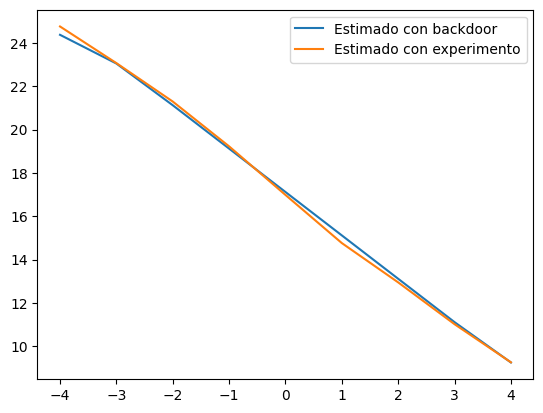

In [ ]:
# E(y | do(x)) = sum_y y P(y|do(x))
def media(y_grilla, py_dox):
  dy = y_grilla[1]-y_grilla[0]
  return sum(y_grilla * py_dox)*dy

x_grilla = np.arange(-4,4+1,1)
medias1_estimadas_con_backdoor = []
medias1_estimadas_con_experimento = []
for x in x_grilla:
  medias1_estimadas_con_backdoor.append(media(y_grilla, p1_Y_doX(y_grilla,x=x)[:,0]))

  _,_,Yx = simular1(N=5000, do_x=x)
  medias1_estimadas_con_experimento.append(np.mean(Yx))

#np.sum(y_grilla*p1_Y_doX(y_grilla,x=1)[:,0])*dy
plt.plot(x_grilla, medias1_estimadas_con_backdoor, label="Estimado con backdoor")
plt.plot(x_grilla, medias1_estimadas_con_experimento, label="Estimado con experimento")
plt.legend()
plt.show()

#4

In [ ]:
def simular4(N, do_x=None):
# Si hay intervencion, usar x = do_x, sino generarlo del modelo original

  Z = np.random.normal(size=N, scale=1)
  if do_x is None:
    X = Z**2 + np.random.normal(size=N, scale=1)
  else:
    X = np.full(N, do_x)
  M = 2*Z**2 + 10*X + np.random.normal(size=N, scale=1)
  Y = -1 + 2*M**2 + np.random.normal(size=N, scale=1)
  return Z, X, M, Y

N = 10000
Z4s, X4s, M42, Y4s = simular4(N)

In [ ]:
# Base de la regresi´on
PHI4 = np.concatenate([
np.ones(N).reshape(N, 1),
(X4s**2).reshape(N, 1),
(X4s*Z4s**2).reshape(N, 1),
(Z4s**4).reshape(N, 1)],
axis=1)

# Modelo lineal
blm4= BayesianLinearModel(basis=lambda x: x)
blm4.update(PHI4, Y4s.reshape(N,1) )
print("Evidencia = ", blm4.evidence())

# Estimaciones de los pesos w
m4 = blm4.location
S4 = blm4.dispersion

Evidencia =  -59215.85112322685


In [ ]:
m4

array([[ -1.61081539],
       [199.6661809 ],
       [ 83.86555217],
       [  5.7765888 ]])

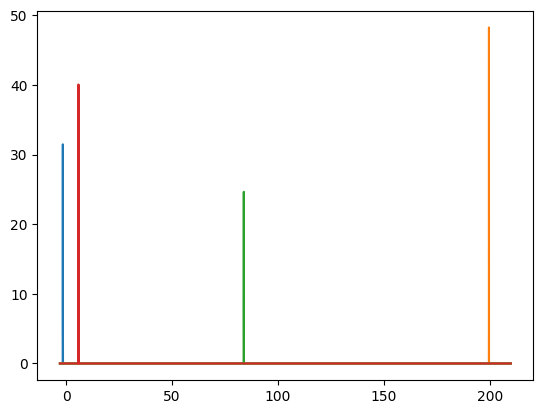

In [ ]:
w_grilla = np.arange(-3,210,0.01)
for i in range(len(blm4.location)):
  plt.plot(w_grilla, norm.pdf(w_grilla, m4[i], np.sqrt(S4[i,i])))

plt.show()

In [ ]:
def p4_Y_doX(y,x,blm4, z_grilla = np.arange(-4,4,0.01)):
  res = 0
  dz = z_grilla[1]-z_grilla[0]
  for z in z_grilla:
    pz = normal(0,1).pdf(z) # Así está en la práctica
    mu_y_xz, S_y_xz, py_xz = blm4.predict(
      X=np.array([1,x**2,x*z**2,z**4]).reshape((1,4)),
      y=np.array([y]), variance=True)
    res += (pz*py_xz)*dz
  return res


# p4_Y_doX corregida
def p4_Y_doX(y, x, blm4, z_grilla=np.arange(-4,4,0.01)):
    res = 0
    dz = z_grilla[1] - z_grilla[0]
    for z in z_grilla:
        pz = stats.norm.pdf(z, loc=0, scale=1)  # Si cambio esta linea la estimada de la realidad observada no se me va a 0 en el último
        mu_y_xz, S_y_xz, py_xz = blm4.predict(
            X=np.array([1, x**2, x*z**2, z**4]).reshape((1, 4)),
            y=np.array([y]), variance=True
        )
        res += (pz * py_xz) * dz
    return res

In [ ]:
def Y_doX(x, N=10000):
# Generar una muestra P(y|do(x))
  Z, X, M, Y = simular4(N, do_x=x)
  return Y

El próximo chunk tarda 30min en correr, ejecutar con precaución

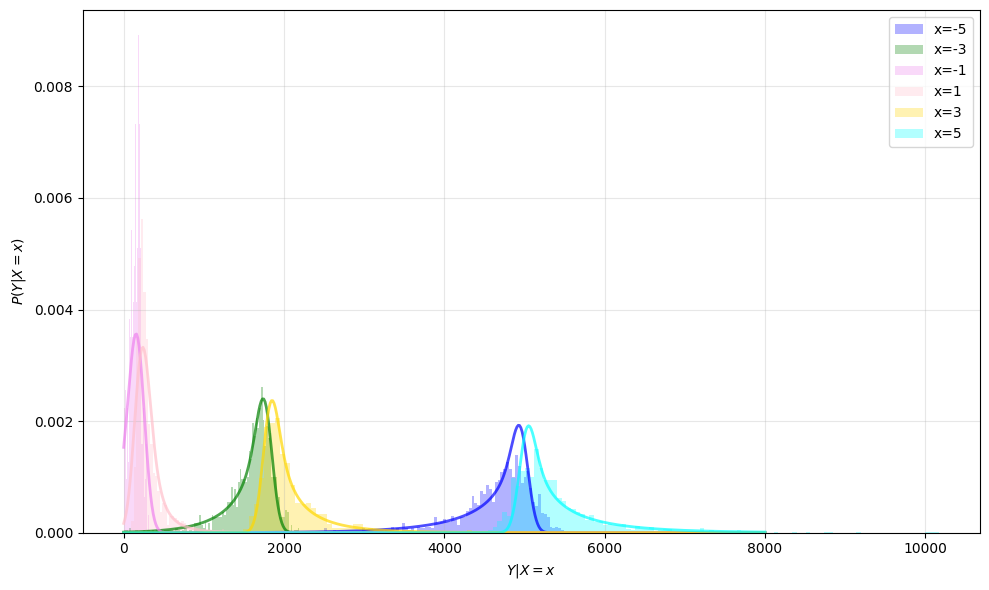

In [ ]:
x_consigna = [-5, -3, -1, 1, 3, 5]

colores = {
    -5: "blue",
    -3: "green",
    -1: "violet",
     1: "pink",
     3: "gold",
     5: "cyan"
}

N_muestras = 1000

y_grilla = np.linspace(0, 8000, 500)

plt.figure(figsize=(10, 6))

for x in x_consigna:
    Y_muestras = Y_doX(x, N=N_muestras)
    p_y_doX = [p4_Y_doX(y, x, blm4) for y in y_grilla]

    color_hist = colores[x]
    color_estimado = colores[x]

    plt.hist(Y_muestras, bins=100, density=True, alpha=0.3,
        color=color_hist, label=f"x={x}")

    plt.plot(y_grilla, p_y_doX, lw=2, color=color_estimado, alpha=0.7)

plt.xlabel(r"$Y|X=x$")
plt.ylabel(r"$P(Y|X=x)$")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


El próximo chunk tarda más de 1 hora en correr, no ejecutar si no es necesario

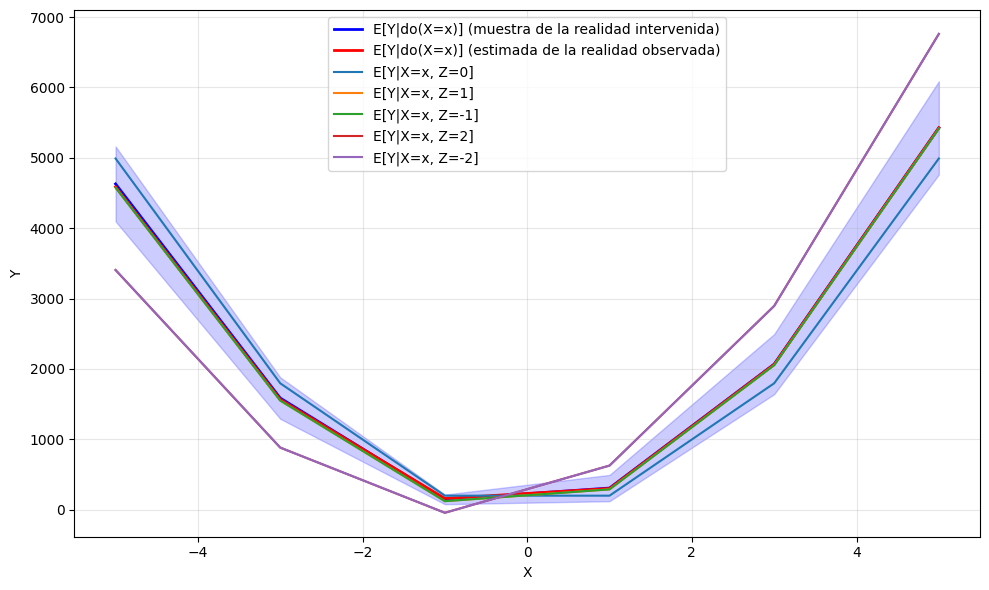

In [ ]:
N = 10000
Z4s, X4s, M42, Y4s = simular4(N)

z_grilla = np.linspace(-4, 4, 100)
y_grilla = np.linspace(Y4s.min(), Y4s.max(), 3000)


# Simular Y|do(X=x)
def Y_doX(x, N=10000):
    _, _, _, Y = simular4(N, do_x=x)
    return Y

# Valores de intervención según el gráfico
x_intervenciones = [-5, -3, -1, 1, 3, 5]
z_valores = [0, 1, -1, 2, -2]
N_muestras = 10000

medias_realidad_intervenida = []
varianzas_realidad_intervenida = []
medias_efecto_general = []
medias_z_especificas = {z: [] for z in z_valores}

for x in x_intervenciones:
    # Realidad intervenida
    Y_muestras = Y_doX(x, N=N_muestras)
    medias_realidad_intervenida.append(np.mean(Y_muestras))
    varianzas_realidad_intervenida.append(np.var(Y_muestras))

    # Estimación del efecto causal general
    p_y_doX = [p4_Y_doX(y, x, blm4) for y in y_grilla]
    p_y_doX = np.array(p_y_doX) / np.sum(p_y_doX)  # Normalizar
    media_efecto_general = np.sum(p_y_doX * y_grilla)
    medias_efecto_general.append(media_efecto_general)

    # Medias específicas para Z
    for z in z_valores:
        mu_y_xz = blm4.predict(
            X=np.array([1, x**2, x*z**2, z**4]).reshape((1, 4)),
            variance=False
        )
        medias_z_especificas[z].append(mu_y_xz[0][0])

plt.figure(figsize=(10, 6))

plt.plot(
    x_intervenciones,
    medias_realidad_intervenida,
    label=r"E[Y|do(X=x)] (muestra de la realidad intervenida)",
    color="blue", lw=2
)
plt.fill_between(
    x_intervenciones,
    np.array(medias_realidad_intervenida) - np.sqrt(varianzas_realidad_intervenida),
    np.array(medias_realidad_intervenida) + np.sqrt(varianzas_realidad_intervenida),
    color="blue", alpha=0.2
)

# Estimación del efecto causal general
plt.plot(
    x_intervenciones,
    medias_efecto_general,
    label=r"E[Y|do(X=x)] (estimada de la realidad observada)",
    color="red", lw=2
)

# Medias condicionales específicas
for z, medias in medias_z_especificas.items():
    plt.plot(
        x_intervenciones, medias, label=rf"E[Y|X=x, Z={z}]", lw=1.5
    )

plt.xlabel(r"X")
plt.ylabel(r"Y")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Notamos que se superponen las líneas cuyo Z tienen igual módulo